In [1]:
import dill
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from utils import id_to_name, mlb, name_to_id
import numpy as np
import pyarrow.parquet as pq

files = {
    "training_mv": "./../zenodo/training_mvalues.parquet",
    "training_meta": "./../zenodo/training_meta.parquet",
    "labtransfer_mv": "./../zenodo/label_transfer_mvalues.parquet",
    "labtransfer_meta": "./../zenodo/label_transfer_meta.parquet",
}

# Load all DataFrames in one line each
training_mv, training_meta, labtransfer_mv, labtransfer_meta = [
    pq.read_table(path).to_pandas() for path in files.values()
]

print(training_mv.shape, labtransfer_mv.shape)
print(training_meta.shape, labtransfer_meta.shape)

selector =  dill.load(open("./../data/GEO/minipatch/minipatch_whole_selector", "rb"))
selection_frequency_threshold = 0.65
selection_freq = pd.DataFrame(selector.Pi_hat_last_k_, index=training_mv.columns)
minipatch_probes = list(selection_freq[selection_freq[0]>=selection_frequency_threshold].index)
labtransfer_mv_minipatch = labtransfer_mv[minipatch_probes]

(10351, 297598) (6608, 297598)
(10351, 7) (6608, 6)


In [2]:
# Ensure no overlapping samples
set(labtransfer_mv.index).intersection(set(training_mv.index))

set()

In [3]:
training_meta.head()

,training.ID,Dataset,FileSeries,Annotated.tissue,UBERON.ID,merged.ID,File
Sample,,,,,,,
GSM2859937,UBERON:0002107,GSE107038,GSE107038,liver,UBERON:0002107,UBERON:0002107,raw/GEO/GSE107038/GSM2859937_10003886118_R03C02
GSM2859938,UBERON:0002107,GSE107038,GSE107038,liver,UBERON:0002107,UBERON:0002107,raw/GEO/GSE107038/GSM2859938_10003886118_R04C02
GSM2859939,UBERON:0002107,GSE107038,GSE107038,liver,UBERON:0002107,UBERON:0002107,raw/GEO/GSE107038/GSM2859939_10003886118_R05C02
GSM2859940,UBERON:0002107,GSE107038,GSE107038,liver,UBERON:0002107,UBERON:0002107,raw/GEO/GSE107038/GSM2859940_10003886118_R06C02
GSM2859941,UBERON:0002107,GSE107038,GSE107038,liver,UBERON:0002107,UBERON:0002107,raw/GEO/GSE107038/GSM2859941_10003886150_R01C01


In [4]:
labtransfer_meta.head()

,merged.ID,Dataset,FileSeries,Annotated.tissue,UBERON.ID,File
Sample,,,,,,
GSM2829678,CL:0000115,GSE106099,GSE106099,endothelial cell,CL:0000115,raw/GEO_labtransfer/GSE106099/GSM2829678_60072...
GSM2829687,CL:0000115,GSE106099,GSE106099,endothelial cell,CL:0000115,raw/GEO_labtransfer/GSE106099/GSM2829687_60072...
GSM2829694,CL:0000115,GSE106099,GSE106099,endothelial cell,CL:0000115,raw/GEO_labtransfer/GSE106099/GSM2829694_60578...
GSM2829688,CL:0000115,GSE106099,GSE106099,endothelial cell,CL:0000115,raw/GEO_labtransfer/GSE106099/GSM2829688_60072...
GSM2829680,CL:0000115,GSE106099,GSE106099,endothelial cell,CL:0000115,raw/GEO_labtransfer/GSE106099/GSM2829680_60072...


In [5]:
clf = dill.load(open(f"./../data/GEO/minipatch/multilabel_whole_clf", 'rb'))

pred_proba_list = clf.predict_proba(labtransfer_mv_minipatch.values)
pred_proba_df = pd.DataFrame(index=labtransfer_meta.index, columns=mlb.classes_)
for i, tissue in enumerate(mlb.classes_):
    pred_proba_df[tissue] = pred_proba_list[i][:,1]

In [6]:
pred = pred_proba_df.apply(lambda row: row[row > 0.5].index.tolist(), axis=1)

In [7]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
from collections import Counter
import logging

In [8]:
with open('./../annotation/ontologies.dill', 'rb') as f:
    [full_ontology, training_ontology] = dill.load(f)

# prelim plot

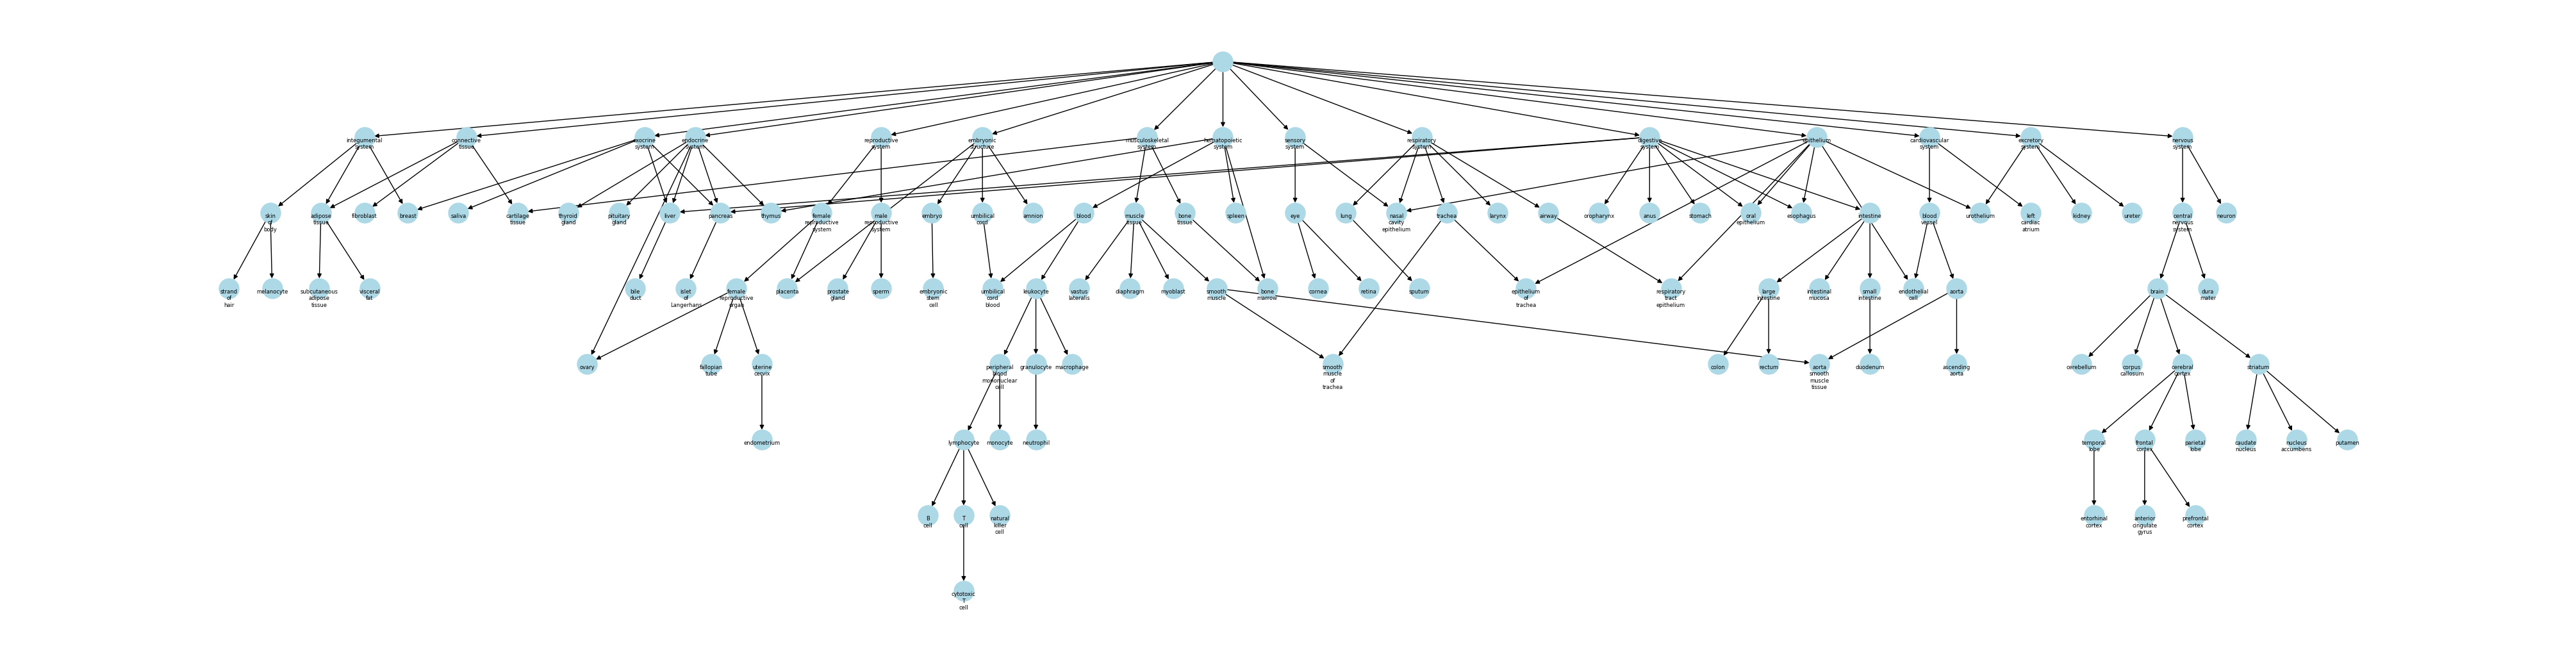

In [9]:
def prelim_plot(graph):
    plt.figure(figsize=(40, 10))
    pos = nx.drawing.nx_agraph.graphviz_layout(graph, prog='dot', root='root')
    labels = {node: id_to_name[node][0].replace(' ', '\n') if node != "root" else "" for node in graph.nodes()}
    nx.draw(graph, pos, node_color='lightblue', node_size=500, font_size=20, font_weight='bold', arrows=True)
    nx.draw_networkx_labels(graph, pos, labels, font_size=6, verticalalignment="top")
    plt.show()
prelim_plot(full_ontology)

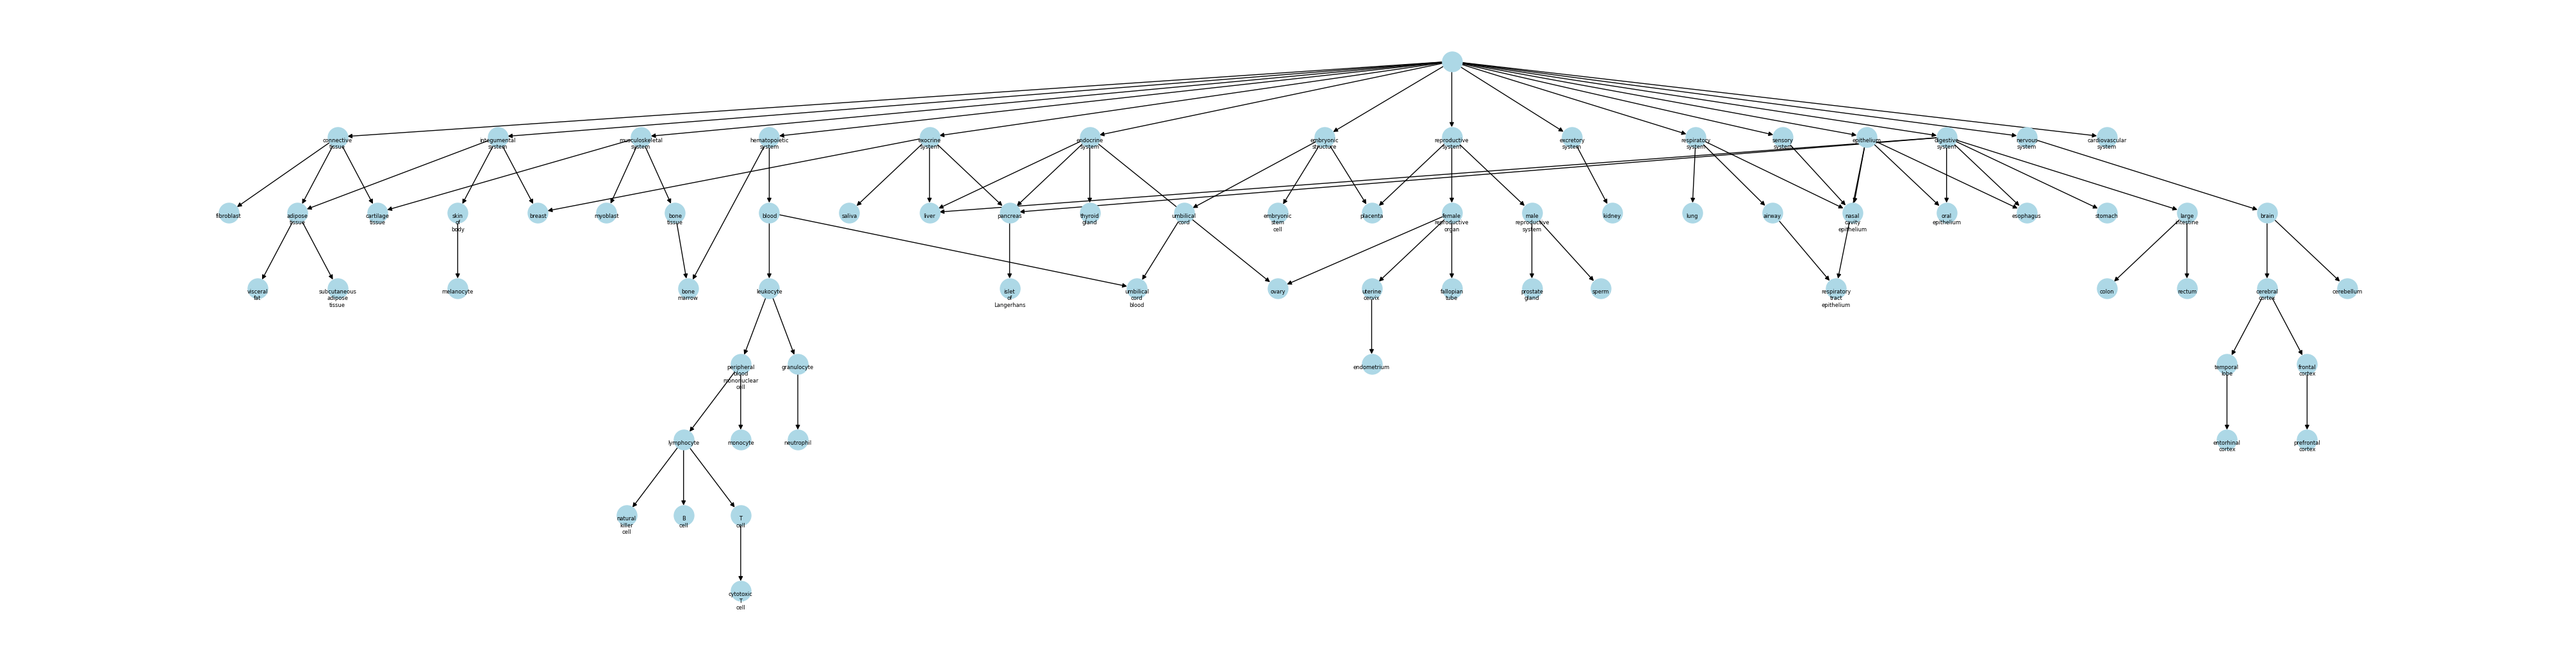

In [10]:
prelim_plot(training_ontology)

# histogram

2025-04-17 09:28:44,819 - INFO - Before filtering: 31 tissues.
2025-04-17 09:28:44,820 - INFO - After filtering: 30 tissues.


Removing: UBERON:0003410: oropharyngeal gland


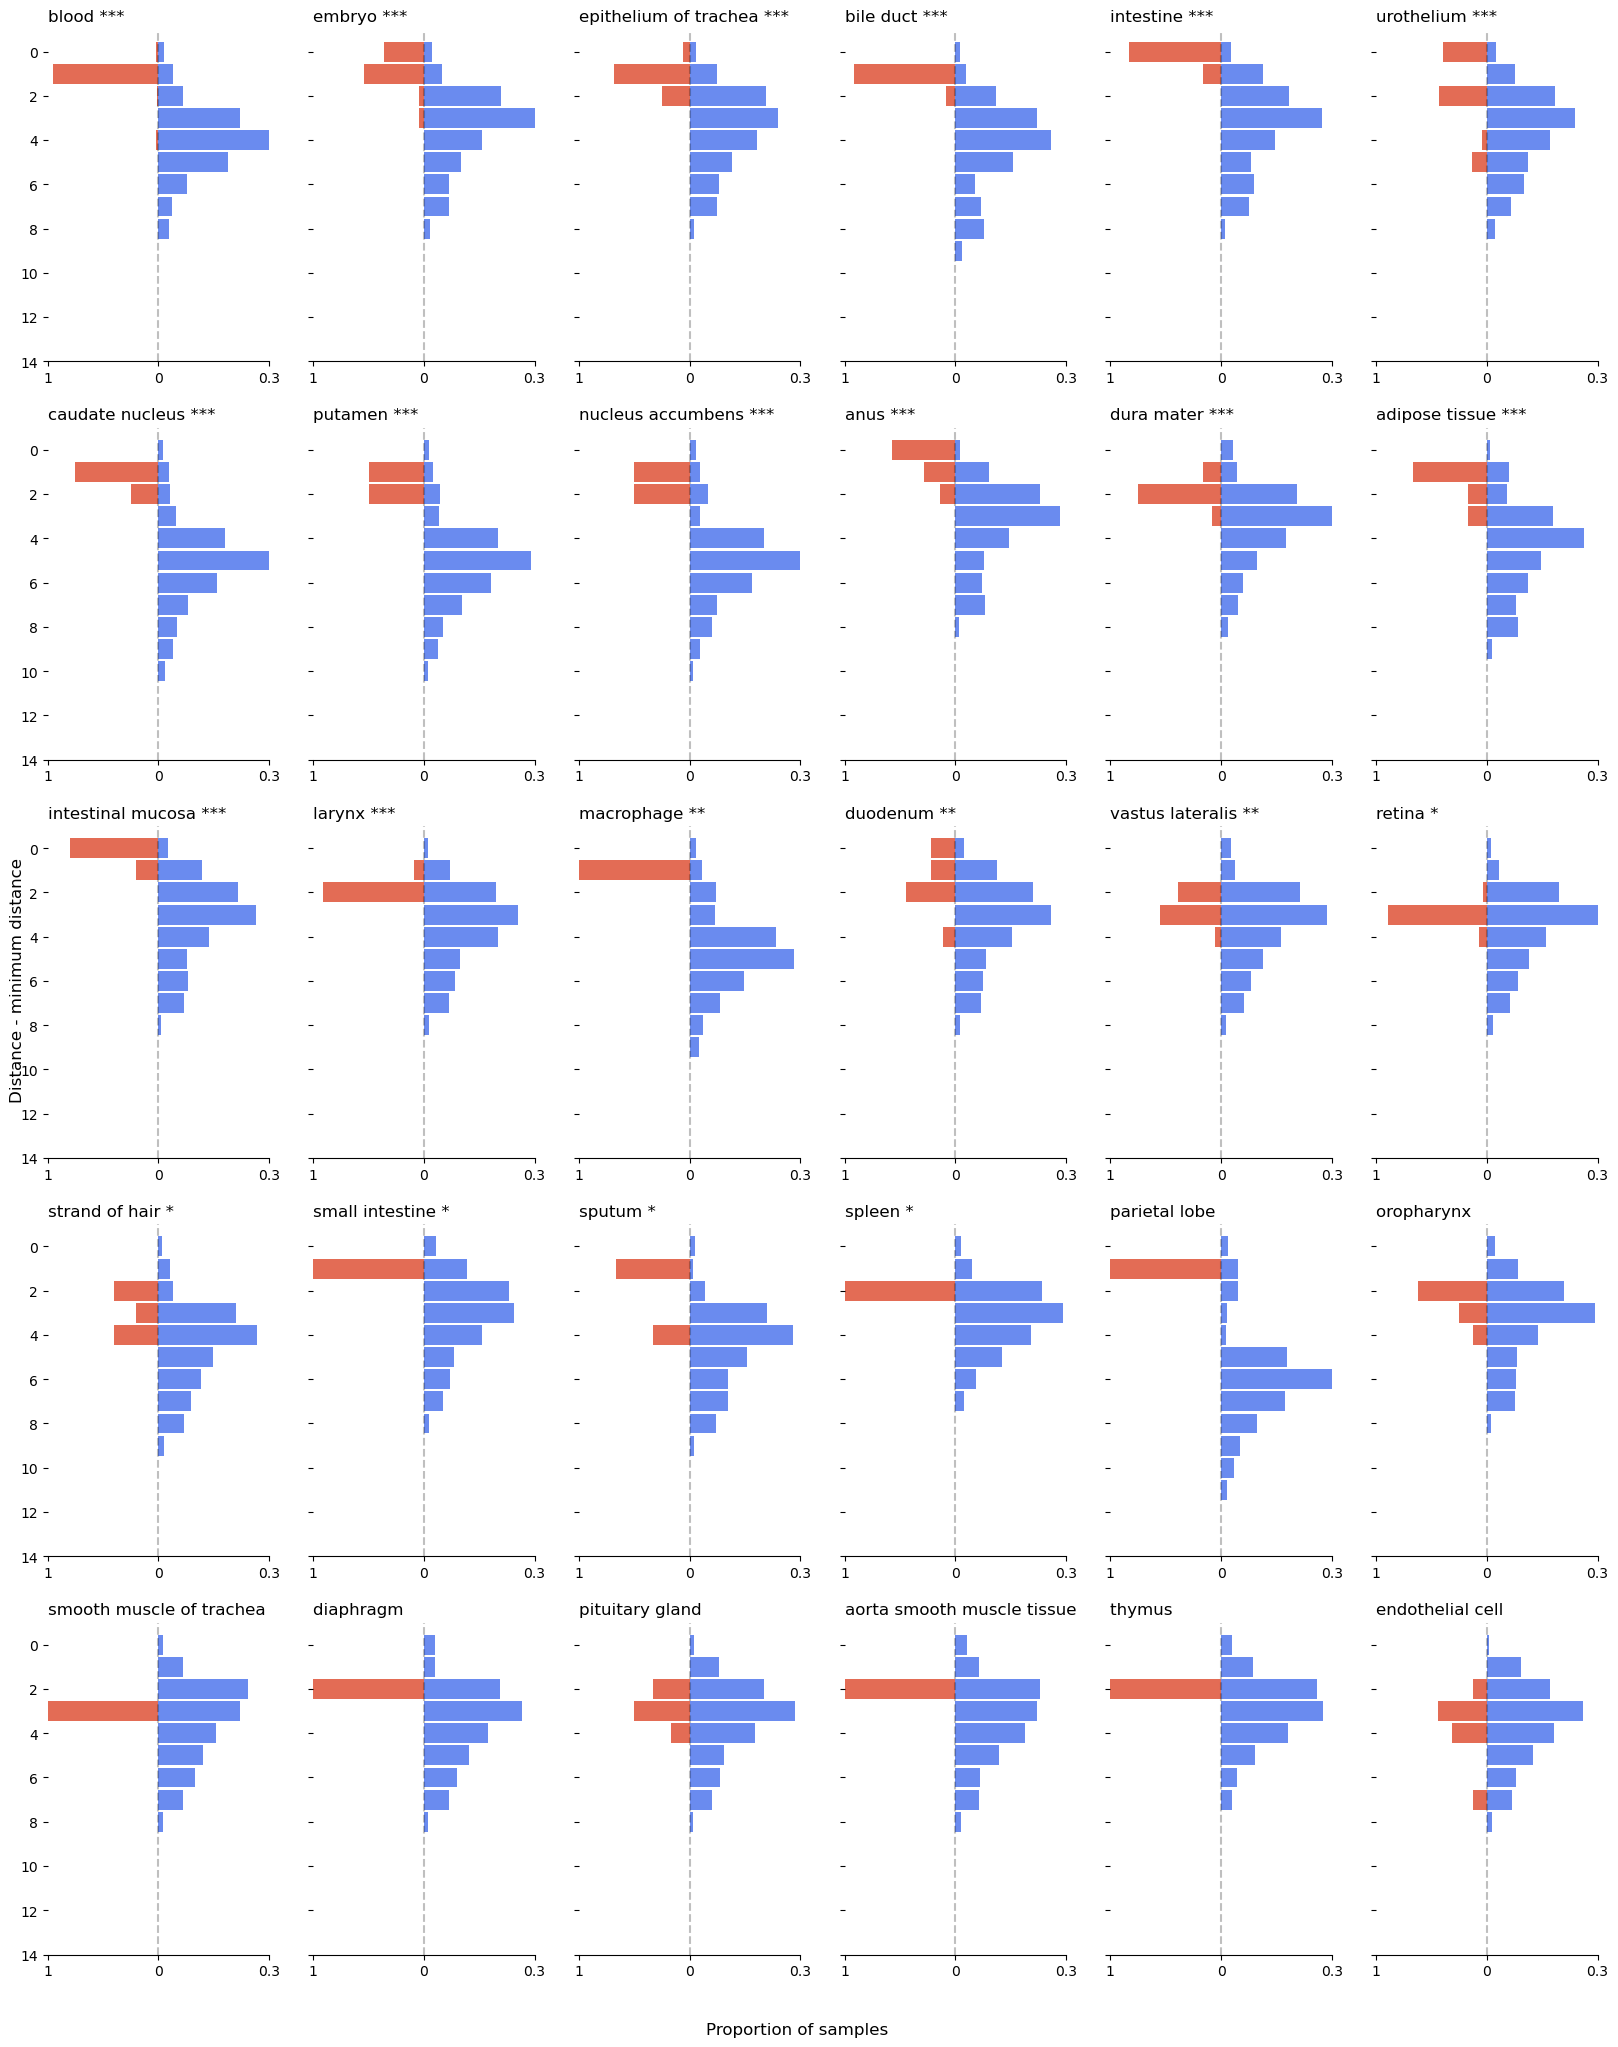

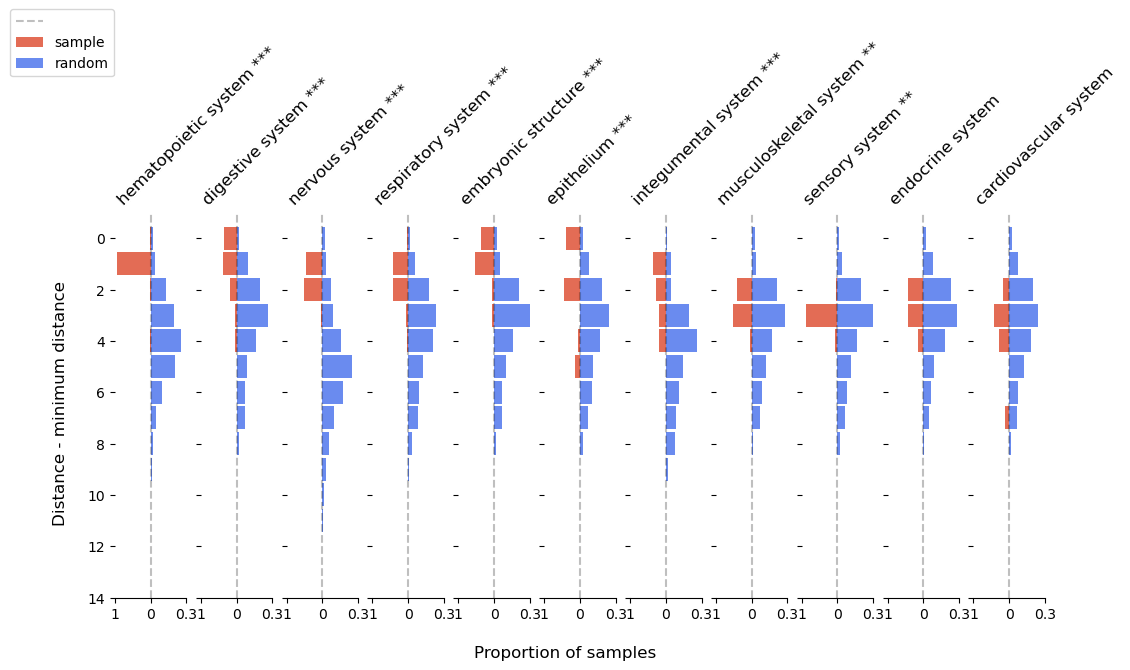

In [11]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class ZeroShotAnalysis:
    def __init__(self, pred_proba_df, labtransfer_meta, full_ontology, training_ontology, name_to_id, id_to_name):
        self.pred_proba_df = pred_proba_df
        self.labtransfer_meta = labtransfer_meta
        self.full_ontology = full_ontology
        self.training_ontology = training_ontology
        self.name_to_id = name_to_id
        self.id_to_name = id_to_name
        self.full_ontology_undirected = nx.MultiGraph(full_ontology)

    def get_distance(self, n, n_type="name", display=False):
        """Get shortest path distance between nodes in a graph."""
        if isinstance(self.full_ontology_undirected, nx.MultiDiGraph): 
            logger.error("ERROR: g must be undirected")
            return np.nan

        if n_type == "name":
            n = [self.name_to_id[n[0]], self.name_to_id[n[1]]]

        try:
            distance = nx.shortest_path_length(self.full_ontology_undirected, source=n[0], target=n[1])
            if not isinstance(distance, int): 
                logger.warning(f"Distance calculation issue: {self.name_to_id[n[0]], self.name_to_id[n[1]], distance}")
            return distance
        except Exception:
            if display:
                logger.info(f"{self.id_to_name[n[0]]} and {self.id_to_name[n[1]]}: no distance")
            return np.nan

    def calculate_sample_ave_distance(self, true):
        """Calculate average distance for each sample based on predictions."""
        sample_ave_distance = pd.Series(index=self.pred_proba_df.index)

        for idx, row in self.pred_proba_df.iterrows():
            pos_pred = list(row[row > 0.50].index)
            if len(pos_pred) == 0:
                continue

            pred_distances = [
                self.get_distance([true.loc[idx], pred], n_type="id", display=False)
                for pred in pos_pred
            ]
            sample_ave_distance[idx] = np.mean(pred_distances)

        return sample_ave_distance

    def calculate_distances_per_tissue(self, sample_ave_distance, true):
        """Calculate distances per tissue."""
        distances_per_tissue = {}
        for tissue in np.unique(true.values):
            distances_per_tissue[tissue] = sample_ave_distance[
                list(self.labtransfer_meta[self.labtransfer_meta['merged.ID'] == tissue].index)
            ].values.tolist()

        return distances_per_tissue

    def filter_distances(self, distances_per_tissue):
        """Filter out tissues with no predictions."""
        logger.info(f"Before filtering: {len(distances_per_tissue)} tissues.")
        for tissue, distances in distances_per_tissue.items():
            if np.all(np.isnan(distances)):
                print(f"Removing: {tissue}: {id_to_name[tissue][0]}")
        distances_per_tissue = {
            tissue: distances for tissue, distances in distances_per_tissue.items()
            if not np.all(np.isnan(distances))
        }
        logger.info(f"After filtering: {len(distances_per_tissue)} tissues.")
        return distances_per_tissue

    def create_tissue_df(self, tissue, distances_per_tissue):
        """Create a DataFrame for distances by tissue."""
        tissue_df = pd.DataFrame(columns=['tissue', 'sample_or_random', 'distance'])
        tissue_random = [
            self.get_distance([tissue, random.sample(self.training_ontology.nodes, 1)[0]], n_type="id")
            for _ in range(1000)
        ]
        min_distance = self.compute_min_distance(tissue)

        # Adjust distances
        dist = [dist - min_distance for dist in distances_per_tissue[tissue]]
        rand = [dist - min_distance for dist in tissue_random]

        tissue_df['distance'] = dist + rand
        tissue_df['sample_or_random'] = ['sample'] * len(dist) + ['random'] * len(rand)
        tissue_df['tissue'] = tissue

        return tissue_df

    def compute_min_distance(self, tissue):
        """Compute minimum distance for a tissue."""
        return np.nanmin([
            self.get_distance([tissue, ours], n_type="id")
            for ours in self.training_ontology.nodes
        ])

    def perform_statistical_tests(self, df, annot_pairs):
        """Perform Mann-Whitney U test with permutation method and FDR correction."""
        from scipy.stats import mannwhitneyu
        from statsmodels.stats.multitest import fdrcorrection
        
        combinations_p = []

        for (tissue1, sample1), (tissue1, random1) in annot_pairs:
            # Extract the data for each group
            data1 = df[(df['tissue'] == tissue1) & (df['sample_or_random'] == sample1)]['distance'].dropna()
            data2 = df[(df['tissue'] == tissue1) & (df['sample_or_random'] == random1)]['distance'].dropna()

            # Perform Mann-Whitney U test
            U, p = mannwhitneyu(data1, data2, alternative="less")

            # Store the p-value along with the tissue-sample pair
            combinations_p.append([(tissue1, sample1), p])

        # Apply FDR correction to the p-values
        rejected, p_adjusted = fdrcorrection([pv for comb, pv in combinations_p])

        # Return adjusted p-values for each tissue group
        return {comb[0][0]: p_adj for comb, p_adj in zip(annot_pairs, p_adjusted)}

    def perform_statistical_tests_group(self, df, annot_pairs, node_groups):
        combinations_p = list()
        for (tissue1, sample1), (tissue1, random1) in annot_pairs:
            data1 = df[(df['tissue'].isin(node_groups[tissue1])) & (df['sample_or_random'] == sample1)]['distance']
            data1 = data1[data1.notna()]
            data2 = df[(df['tissue'].isin(node_groups[tissue1])) & (df['sample_or_random'] == random1)]['distance']
            data2 = data2[data2.notna()]
            # Significance
            U, p = mannwhitneyu(data1, data2, alternative="less")
            combinations_p.append([(tissue1, sample1), p])
                
        rejected, p_adjusted = fdrcorrection([pv for comb, pv in combinations_p])
        significant_combinations = [(comb, p_adj) for comb, p_adj in zip(annot_pairs, p_adjusted) 
                                    if p_adj<0.05]
        return {comb[0][0]: p_adj for comb, p_adj in zip(annot_pairs, p_adjusted)}

    def list_to_bin_dict(self, test_df, tissue, display=False):
        """Convert list of distances to a binomial dictionary."""
        result = []
        
        for category in ["sample", "random"]:
            test_list = test_df[(test_df['tissue'].isin(tissue)) & (test_df['sample_or_random'] == category)]['distance'].dropna().tolist()
            
            if len(set(test_list)) == 1:
                result.append({round(test_list[0]): 1})
            else:
                rounded_data = [round(d) for d in test_list]
                result.append({num: count / len(rounded_data) for num, count in dict(Counter(rounded_data)).items()})
            
            if display:
                logger.info(f"{category}: {test_list}")

        return self.combine_dicts(result[0], result[1])

    def combine_dicts(self, dict1, dict2):
        """Combine two dictionaries with lists of values."""
        combined_dict = {}
        for key, value in dict1.items():
            combined_dict[key] = [value] + [dict2.get(key, 0)]

        for key, value in dict2.items():
            if key not in combined_dict:
                combined_dict[key] = [0, value]

        return combined_dict

    def survey_zero(self, results, category_names, tissue=None, ax=None):
        """
        Visualize the survey data with horizontal stacked bars.
        """
        neg_xlim = 1
        pos_xlim = 0.3
        
        results = dict(sorted(results.items()))
        
        labels = list(results.keys())
        data = np.array(list(results.values()))
        data[:, 0] = data[:, 0] / neg_xlim
        data[:, 1] = data[:, 1] / pos_xlim
        data_cum = data.cumsum(axis=1)
        
        # Color Mapping
        category_colors = plt.get_cmap('coolwarm_r')(
            np.linspace(0.15, 0.85, data.shape[1]))
        
        if ax is None:
            ax = plt.subplot()
        else:
            ax = ax
            
        ax.set_xlim(-neg_xlim, pos_xlim)
        ax.set_xticks([-1, 0, 1])
        ax.set_xticklabels([1, 0, 0.3])

        # Plot Bars
        for i, (colname, color) in enumerate(zip(category_names, category_colors)):
            widths = data[:, i]
            offsets = data[:, 0]
            starts = data_cum[:, i] - widths - offsets
            rects = ax.barh(labels, widths, left=starts, height=0.9,
                            label=colname, color=color)
        
        # Add Zero Reference Line
        ax.axvline(0, linestyle='--', color='black', alpha=.25)
        
        # Remove spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        return ax

    def plot_zero_shot(self, df, tissue_to_pv, sorted_labels):
        """Plot zero-shot analysis using bar chart in a grid layout."""
        n_cols = 6  # Adjust this to set the number of columns in the grid
        n_rows = (len(sorted_labels) + n_cols - 1) // n_cols  # Calculate rows required

        fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), sharey=True)
        ax = ax.flatten()  # Flatten the axes to iterate easily

        for i, tissue in enumerate(sorted_labels):
            ax[i].set_ylim(14, -1)
            ax[i] = self.survey_zero(self.list_to_bin_dict(df, [tissue]), 'sample_or_random', [tissue], ax[i])
            sig = self.get_significance(tissue_to_pv[tissue])
            ax[i].set_title(f"{self.id_to_name[tissue][0]} {sig}", rotation=0, loc='left')

        # Hide unused subplots
        for j in range(len(sorted_labels), len(ax)):
            ax[j].axis('off')

        fig.text(0.5, 0.08, 'Proportion of samples', ha='center', va='center', fontsize=12)
        fig.text(0.11, 0.5, 'Distance - minimum distance', ha='center', va='center', rotation='vertical', fontsize=12)

        plt.savefig("./../figures/zeroshot_hist_grid.pdf", bbox_inches='tight', dpi=300)
        plt.show()

    def plot_zero_shot_group(self, df, groups_to_pv, node_groups, sorted_groups):
        """Plot zero-shot analysis using bar chart."""
        fig, ax = plt.subplots(1, len(sorted_groups), sharey=True, figsize=(12, 5))
        
        for i, tissue in enumerate(sorted_groups):
            ax[i].set_ylim(14, -1)
            ax[i] = self.survey_zero(self.list_to_bin_dict(df, node_groups[tissue]), 'sample_or_random', node_groups[tissue], ax[i])
            sig = self.get_significance(groups_to_pv[tissue])
            ax[i].set_title(f"{self.id_to_name[tissue][0]} {sig}", rotation=45, loc='left')
        
        fig.text(0.5, 0, 'Proportion of samples', ha='center', va='center', fontsize=12)
        fig.text(0.08, 0.5, 'Distance - minimum distance', ha='center', va='center', rotation='vertical', fontsize=12)
        fig.legend(["", "sample","random"], bbox_to_anchor=(0.13, 1.3))
        
        plt.savefig("./../figures/zeroshot_grouped.pdf", bbox_inches='tight', dpi=300)
        plt.show()

    def get_significance(self, p_value):
        """Determine significance based on p-value."""
        if p_value < 0.001:
            return "***"
        elif p_value < 0.01:
            return "**"
        elif p_value < 0.05:
            return "*"
        else:
            return ""

    def group_nodes(self, tissue_to_distance):
        all_nodes = [x for x in tissue_to_distance.keys()]
        node_groups = dict()
        for big_node in [x for x in self.full_ontology.successors('root')]:
            big_children = nx.descendants(self.full_ontology, big_node)
            if len(big_children)==0: continue
            
            if 'epithelium' in id_to_name[big_node]: 
                big_children_in_nodes =  [node for node in all_nodes if node in big_children]
            else: 
                big_children_in_nodes = [node for node in all_nodes if ((node in big_children) and ('epithelium' not in id_to_name[node]))]
            if len(big_children_in_nodes)==0: continue
            all_nodes = list(set(all_nodes) - set(big_children_in_nodes))
            node_groups[big_node] = [x for x in big_children_in_nodes]
        
            if len(all_nodes)==0: break
        
        return node_groups

    def main(self):
        # Calculate average distance
        true = self.labtransfer_meta['merged.ID']
        sample_ave_distance = self.calculate_sample_ave_distance(true)

        # Calculate distances per tissue
        distances_per_tissue = self.calculate_distances_per_tissue(sample_ave_distance, true)

        # Filter out tissues with no predictions
        distances_per_tissue = self.filter_distances(distances_per_tissue)
        self.distances_per_tissue = distances_per_tissue

        # Initialize DataFrame for storing results
        df = pd.DataFrame(columns=['tissue', 'sample_or_random', 'distance'])

        # Process each tissue
        for tissue in distances_per_tissue:
            tissue_df = self.create_tissue_df(tissue, distances_per_tissue)
            df = pd.concat([df, tissue_df])
        self.df = df

        # Perform statistical tests
        labels = ['sample', 'random']
        annot_pairs = [((tissue, labels[0]), (tissue, labels[1])) for tissue in df['tissue'].unique()]
        tissue_to_pv = self.perform_statistical_tests(df, annot_pairs)
        self.tissue_to_pv = tissue_to_pv

        # Sort tissues based on p-value
        sorted_labels = sorted(df['tissue'].unique(), key=lambda x: tissue_to_pv[x])

        # Plot the results
        self.plot_zero_shot(df, tissue_to_pv, sorted_labels)

        # Group nodes by 'root' children
        node_groups = self.group_nodes(distances_per_tissue)

        # Process and perform statistical test 
        annot_pairs = [((tissue, labels[0]), (tissue, labels[1])) for tissue in node_groups.keys()]
        group_to_pv = self.perform_statistical_tests_group(df, annot_pairs, node_groups)

        # Sort groups based on p-value
        sorted_groups = [x for x in sorted(node_groups.keys(), key=lambda x: group_to_pv[x])]

        # Plot the results
        self.plot_zero_shot_group(df, group_to_pv, node_groups, sorted_groups)

analysis = ZeroShotAnalysis(pred_proba_df, labtransfer_meta, full_ontology, training_ontology, name_to_id, id_to_name)
analysis.main()

# ontology by probability

In [12]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

def plot_sample_with_proba(graph, meta, pred_proba_df, sample_idx, colormap='Wistia', default_color='lightgrey'):
    """
    Plots a NetworkX graph and colors nodes based on prediction probabilities. 
    Missing probabilities are colored light grey.
    """
    probabilities = pred_proba_df.loc[sample_idx]
    norm = Normalize(vmin=probabilities.min(), vmax=probabilities.max())
    sm = ScalarMappable(cmap=colormap, norm=norm)

    node_colors = [
        sm.to_rgba(probabilities.get(node, np.nan)) if node in probabilities else default_color
        for node in graph.nodes()
    ]
    
    labels = {node: id_to_name[node][0].replace(' ', '\n') if node != "root" else "" for node in graph.nodes()}
    
    plt.figure(figsize=(40, 10))
    
    # Use graphviz_layout for a DAG-like (tree-like) layout
    pos = nx.drawing.nx_agraph.graphviz_layout(graph, prog='dot')
    
    # Draw the graph
    nx.draw(graph, pos, node_color=node_colors, node_size=500, font_size=10, font_weight='bold', arrows=True)
    nx.draw_networkx_labels(graph, pos, labels, font_size=6, verticalalignment="top")
    
    # Draw a circle around the node corresponding to the 'merged ID'
    training_id_node = meta.loc[sample_idx]['merged.ID']
    
    # Highlight the node corresponding to the 'training ID' by drawing it again with a different outline
    if training_id_node in pos:
        nx.draw_networkx_nodes(graph, pos, nodelist=[training_id_node], node_color='none', edgecolors='red', node_size=800, linewidths=2)
    
    sm.set_array(probabilities.values)
    plt.colorbar(sm, label="Prediction Probability")
    plt.title(f"Graph Colored by Prediction Probabilities (Sample {sample_idx})")
    plt.show()

# display pretty

In [13]:
shorter_name = {'peripheral blood mononuclear cell': 'pbmc', 'natural killer cell': 'nk cell'}

labtransfer_meta['merged.Name'] = labtransfer_meta['merged.ID'].apply(lambda x: id_to_name.get(x, 'Unknown'))
labtransfer_meta['Display.Name'] = labtransfer_meta['merged.Name'].replace(shorter_name)
id_to_name_short = {k:[shorter_name[v[0]]] if v[0] in shorter_name else [v[0]] for k, v in id_to_name.items()}

In [14]:
def display_proba_pretty(graph, meta, avg_proba, tissue_id, figsize=(35, 10), colormap='GnBu', default_color='lightgrey', save=False, id_to_name=id_to_name, sample=False):
    """
    Plots a NetworkX graph and colors nodes based on prediction probabilities. 
    """

    plt.figure(figsize=figsize)
    plt.axis('off')
    
    norm = Normalize(vmin=0, vmax=1)
    sm = ScalarMappable(cmap=colormap, norm=norm)

    node_colors = [
        sm.to_rgba(avg_proba.get(node, np.nan)) if node in avg_proba else default_color
        for node in graph.nodes()
    ]

    if id_to_name:
        labels = {node: id_to_name[node][0].replace(' ', '\n') if node != "root" else "" for node in graph.nodes()}
        
    # Use graphviz_layout for a DAG-like (tree-like) layout
    pos = nx.drawing.nx_agraph.graphviz_layout(graph, prog='dot')
    
    nx.draw_networkx_edges(graph, pos, arrowsize=3, edge_color="#A9A9A9", alpha=0.35)
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=60, linewidths=1, edgecolors='lightgray')
    
    # hack for moving labels away from nodes
    pos_off = {}
    y_off = -10  # offset on the y axis
    for k, v in pos.items():
        pos_off[k] = (v[0], v[1]+y_off)
    nx.draw_networkx_labels(graph, pos_off, labels, font_size=6,verticalalignment="top")
    
    sm.set_array(avg_proba.values)
    plt.colorbar(sm, label="Prediction Probability")
    plt.title(f"Graph Colored by Avg Prediction Probabilities (Tissue: {id_to_name[tissue_id][0]})")
    if save:
        if sample:
            plt.savefig(f'./../figures/{id_to_name[tissue_id][0]}_sample.pdf', dpi=300)
        else:
            plt.savefig(f'./../figures/{id_to_name[tissue_id][0]}_tissue.pdf', dpi=300)
    plt.show()
    
def training_ontology_with_avg_proba(graph, meta, merged_id, proba_df, save=False, sample=False):
    samples = meta[meta['merged.ID'] == merged_id].index
    avg_proba = proba_df.loc[samples].mean(axis=0)
    display_proba_pretty(graph, meta, avg_proba, merged_id, figsize=(33,9), colormap='GnBu', save=save, id_to_name=id_to_name_short, sample=sample)

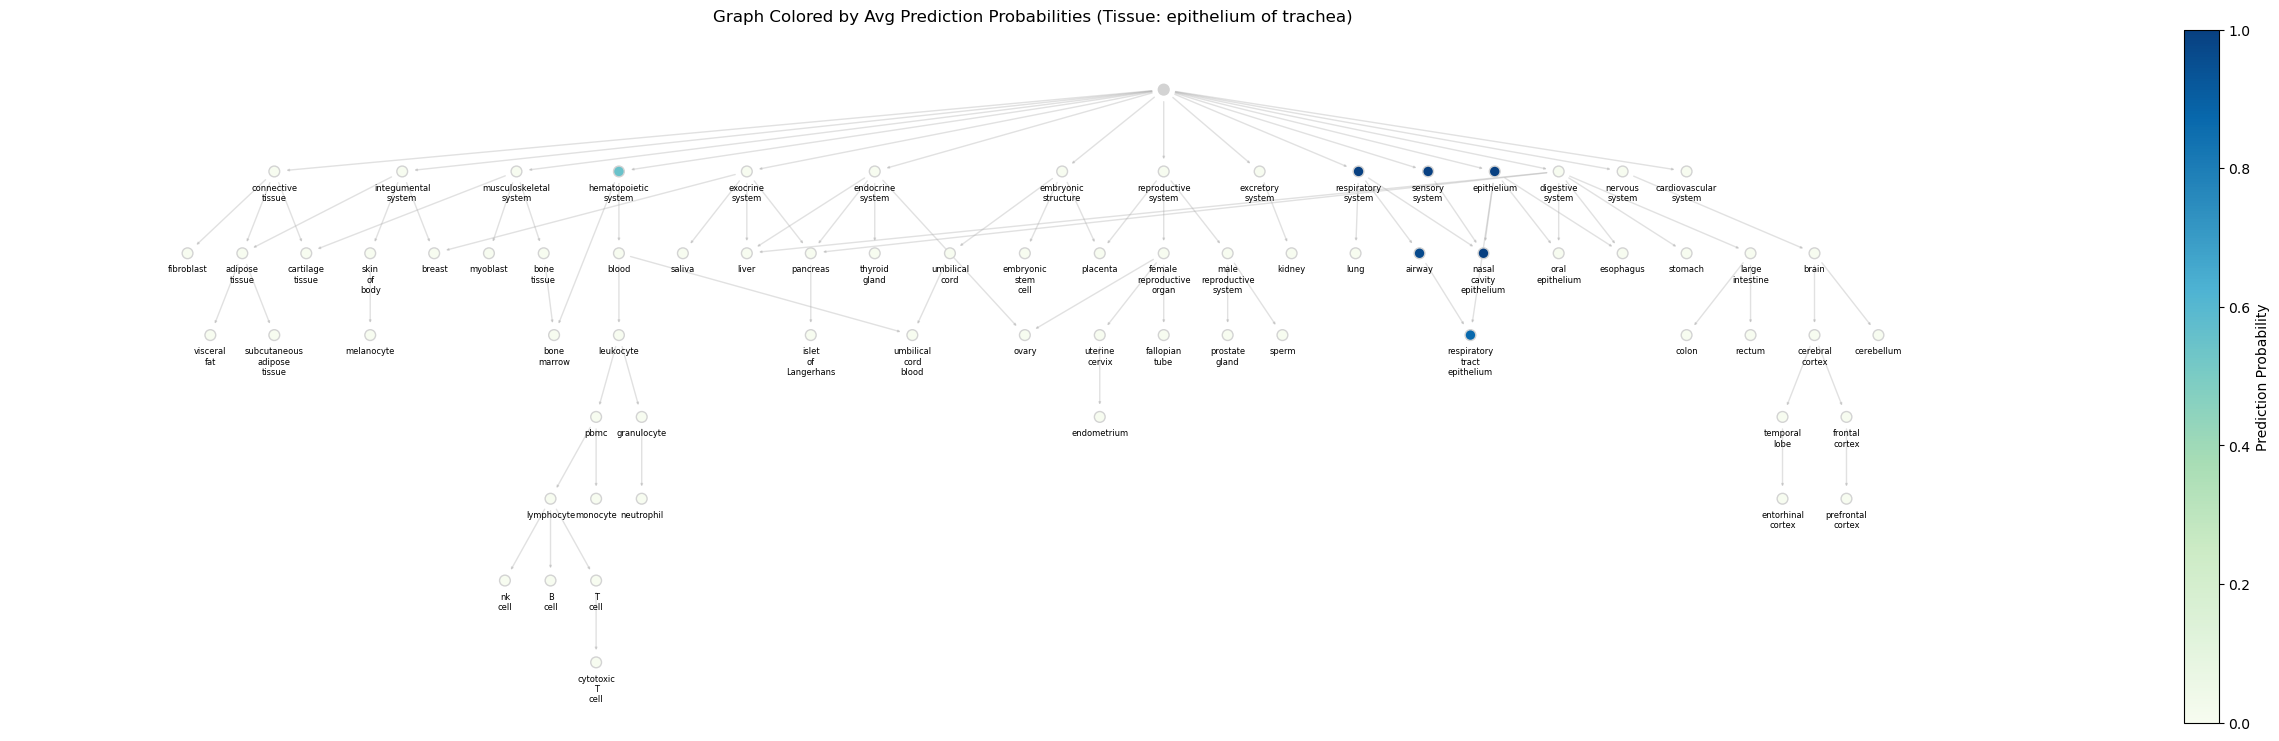

In [15]:
# Single sample

tissue = 'epithelium of trachea'

samples = labtransfer_meta[labtransfer_meta['merged.ID'] == name_to_id[tissue][0]].index[0]
# Compute the average probability for each node
sample_proba = pred_proba_df.loc[samples]

display_proba_pretty(training_ontology, labtransfer_meta, sample_proba, name_to_id[tissue][0], figsize=(33,9), colormap='GnBu', save=True, 
                     id_to_name=id_to_name_short, sample=True)

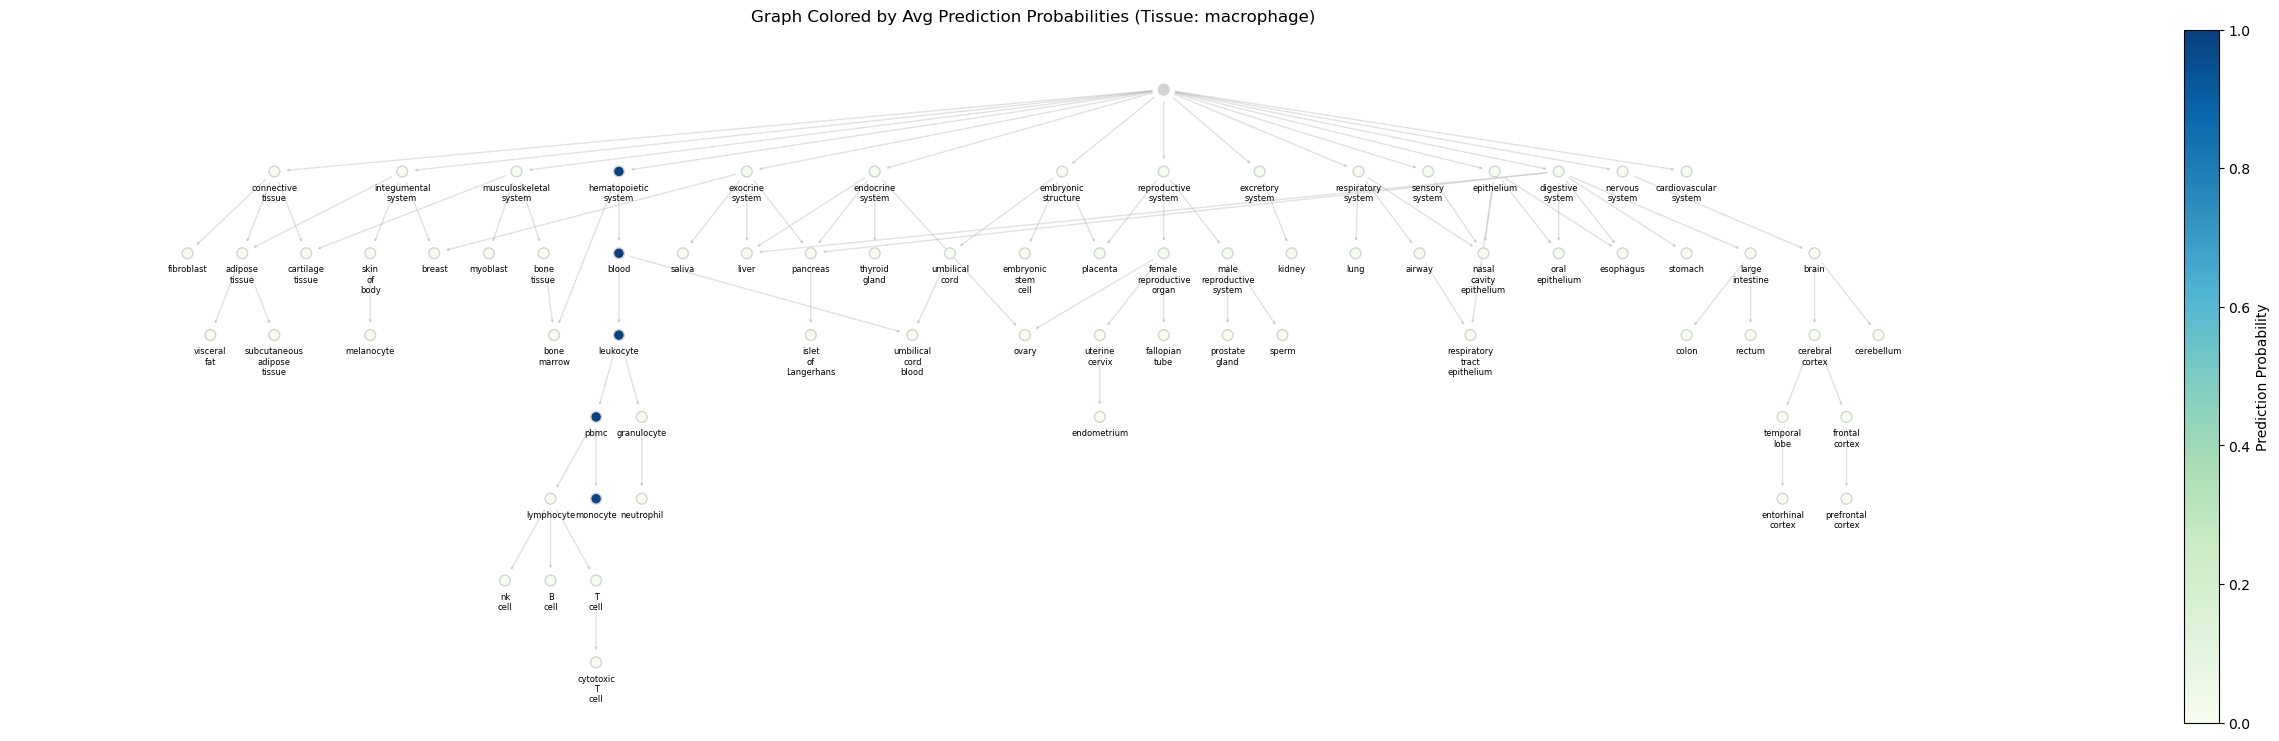

In [16]:
# Tissue average

tissue = 'macrophage'

samples = labtransfer_meta[labtransfer_meta['merged.ID'] == name_to_id[tissue][0]].index
# Compute the average probability for each node
sample_proba = pred_proba_df.loc[samples].mean(axis=0)

display_proba_pretty(training_ontology, labtransfer_meta, sample_proba, name_to_id[tissue][0], figsize=(33,9), colormap='GnBu', save=True, 
                     id_to_name=id_to_name_short, sample=False)